# Detecting Mine Perimeter with Segment Geospatial

## Overview

We use the [samgeo](https://samgeo.gishub.org/) package to segment a GeoTIFF image of a mining area. To ensure we get only the mine boundary, we will prompt the model with a set of 'foreground' and 'background' points.

The image used here is a RGB composite of a mining area derived from a Sentinel-2 image. The image has been exported from Google Earth Engine. See [reference script](https://code.earthengine.google.co.in/54fc87178f1a0cc31e06b9314b14428f).

In [1]:
# Installlation of segment-geospatial can take a few minutes. Please be patient
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install segment-geospatial rioxarray

In [12]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import rioxarray as rxr
from samgeo import SamGeo

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [13]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

image = 's2_mines_rgb.tif'

download(data_url + image)


In [14]:
image_path = os.path.join(data_folder, image)
image = rxr.open_rasterio(image_path)

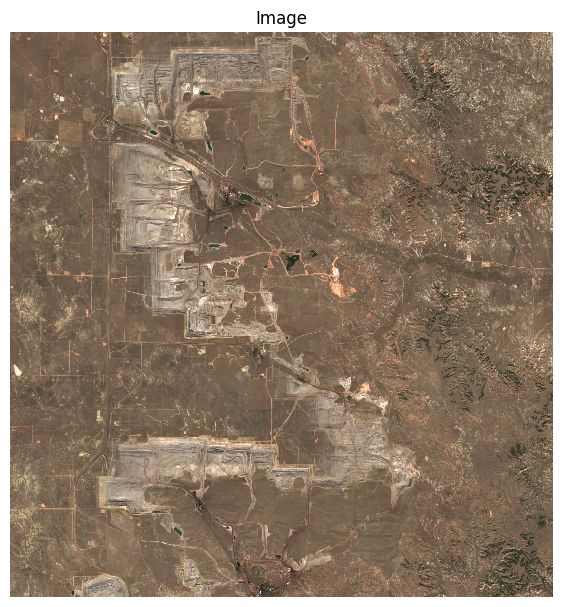

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7,10)
image.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('Image')
plt.show()

## Segmentation with Training Samples

If we wanted to extract boundaries for a lot of mines without manually adding training data, we can use a set of training samples to prompt the model. These training samples can be automatically generated using existing databases such as [Global mining footprint mapped from high-resolution satellite imagery
](https://doi.org/10.1038/s43247-023-00805-6) the following method:

* Foreground Points: Take the mine polyogn and buffer it inwards by XX meters. Sample N points within the buffer.
* Background Points: Take the mine polygon and buffer is outwards by XX meters. Take the difference between the AOI and buffer. Sample M points from the resulting region.

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

In [18]:
mask = 'mining_perimeter.tif'
training_mask_path = os.path.join(output_folder, mask)
vector = 'mining_perimeter.gpkg'
training_vector_path = os.path.join(output_folder, vector)

In [19]:
foreground_coords = [
    [-105.2030365777389, 43.59243279130138],
    [-105.31799690813952, 43.58165243450691],
    [-105.31389118205367, 43.65410388290101],
    [-105.33134051791814, 43.69753284641334],
    [-105.29130968858229, 43.75501854039891],
    [-105.31127393080612, 43.72971279039413],
    [-105.34977689826118, 43.74965309055227]
]

background_coords = [
    [-105.27024271682525, 43.59987910041002],
    [-105.24252906574645, 43.72165914628937],
    [-105.22507972988198, 43.64334727429318],
    [-105.32310394017892, 43.609913006905344],
    [-105.38109732113958, 43.74094305344275]
]

n_foreground_pts = len(foreground_coords)
n_background_pts = len(background_coords)


point_coords = foreground_coords + background_coords

point_labels = [1] * n_foreground_pts + [0] * n_background_pts

sam.set_image(image_path)
sam.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    point_crs='EPSG:4326',
    output=training_mask_path
)

Convert the predicted mask to vectors.

In [20]:
sam.tiff_to_gpkg(
    training_mask_path,
    training_vector_path,
    simplify_tolerance=None)

Visualize the results.

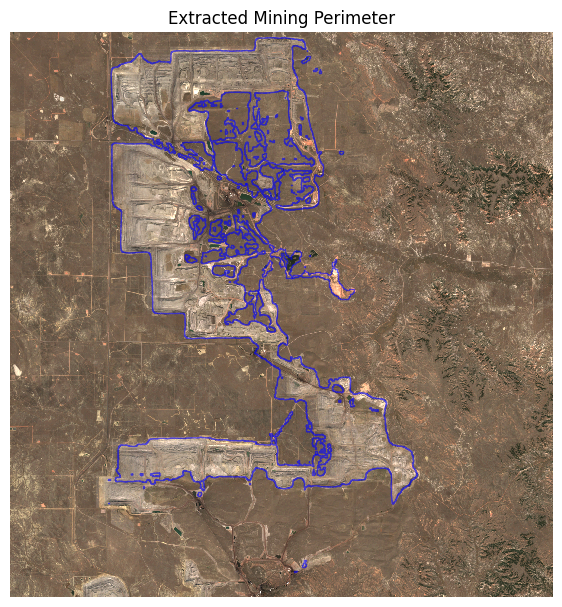

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7,10)
image.plot.imshow(ax=ax)

perimeter_gdf = gpd.read_file(training_vector_path)
perimeter_gdf.plot(
    ax=ax,
    linewidth=1,
    facecolor='none',
    edgecolor='blue',
    alpha=0.6
)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('Extracted Mining Perimeter')
plt.show()

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>